# Tutorial 1: Generating planetary systems

In this tutorial, we will review how to use the Generator class to generate a sample of planetary systems, including how to add or replace steps in the process. 

## Setup

Let's start by importing the necessary module from Bioverse.

In [1]:
# Import the Generator class
from bioverse.generator import Generator
from bioverse.constants import ROOT_DIR

# Import pyplot (for making plots later) and adjust some of its settings
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['font.size'] = 20.

## Loading the Generator

The first step in using Bioverse is to generate a simulated sample of planetary systems. This is accomplished with a Generator object, of which two come pre-installed. Let's open one of them and examine its contents.

In [2]:
# Open the transit mode generator and display its properties
generator = Generator('transit')
generator

Generator with 12 steps:
 0: Function 'create_stars_Gaia' with 6 keyword arguments.
 1: Function 'create_planets_SAG13' with 9 keyword arguments.
 2: Function 'assign_orbital_elements' with 1 keyword arguments.
 3: Function 'geometric_albedo' with 2 keyword arguments.
 4: Function 'impact_parameter' with 1 keyword arguments.
 5: Function 'assign_mass' with no keyword arguments.
 6: Function 'compute_habitable_zone_boundaries' with no keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.
 8: Function 'classify_planets' with no keyword arguments.
 9: Function 'scale_height' with no keyword arguments.
10: Function 'Example1_water' with 3 keyword arguments.
11: Function 'Example2_oxygen' with 2 keyword arguments.

The list above shows each of the steps the Generator runs through in producing the sample of planetary systems. For more information about an individual step, we can display it based on its index:

In [3]:
# Show more about the 'create_planets_SAG13' step
generator.steps[1]

Function 'create_planets_SAG13' with 9 keyword arguments.

Description:
    Generates planets with periods and radii according to SAG13 occurrence rate estimates, but incorporating
    the dependence of occurrence rates on spectral type from Mulders+2015.

    Parameters
    ----------
    d : Table
        Table containing simulated host stars.
    eta_Earth : float, optional
        The number of Earth-sized planets in the habitable zones of Sun-like stars. All occurrence
        rates are uniformly scaled to produce this estimate.
    R_min : float, optional
        Minimum planet radius, in Earth units.
    R_max : float, optional
        Maximum planet radius, in Earth units.
    P_min : float, optional
        Minimum orbital period, in years.
    P_max : float, optional
        Maximum orbital period, in years.
    normalize_SpT : bool, optional
        If True, modulate occurrence rates by stellar mass according to Mulders+2015. Otherwise, assume no
        dependency on stella

Here we see a short description of the planet generation step as well as its keyword arguments, including `eta_Earth`. This specifies the average number of Earth-sized planets in the habitable zones of Sun-like stars, and it is currently set to 7.5% (following Pascucci et al. 2020). Let's change this to a more optimistic value:

In [4]:
# Set eta_Earth = 15%
generator.set_arg('eta_Earth', 0.15)

Some arguments are shared by multiple functions - for example, the `transit_mode` argument tells a couple of functions that only transiting planets are being simulated. By default, it is set to `False`, but we can change that like so:

In [5]:
# Set transit_mode = True for all functions that use it
generator.set_arg('transit_mode', True)

# We can also check on an argument's value as follows:
val = str(generator.get_arg('transit_mode'))
print("\nThe current value of transit_mode is {:s}".format(val))


The current value of transit_mode is True


## Running the Generator

Now, let's use this Generator object to produce an ensemble of transiting planets within 100 parsecs.

In [6]:
sample = generator.generate(d_max=100)
print("Generated a sample of {:d} transiting planets including {:d} exo-Earth candidates.".format(len(sample), sample['EEC'].sum()))

Generated a sample of 17077 transiting planets including 1072 exo-Earth candidates.


Let's plot the period and radius distribution of this planet sample:

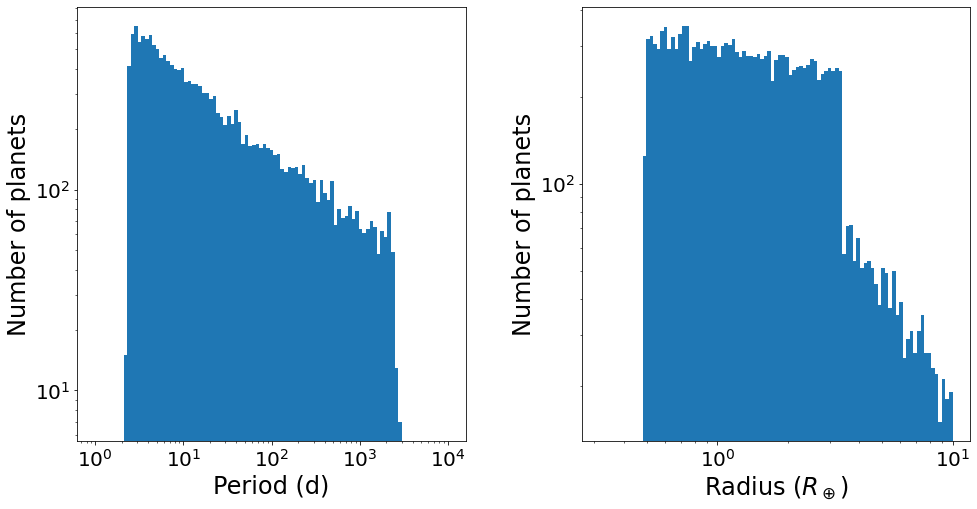

In [7]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

# Period histogram
P = sample['P']
bins = np.logspace(0, 4, 100)
ax[0].hist(P, bins=bins)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Period (d)', fontsize=24)
ax[0].set_ylabel('Number of planets', fontsize=24)

# Radius histogram
R = sample['R']
bins = np.logspace(-0.5,1,100)
ax[1].hist(R, bins=bins)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Radius ($R_\oplus$)', fontsize=24)
ax[1].set_ylabel('Number of planets', fontsize=24)

plt.subplots_adjust(wspace=0.3)

## Adding new steps

Finally, suppose you want to simulate a new planetary property in Bioverse. For example, suppose you want to assign an ocean covering fraction to each planet (`f_ocean_min` < `f_ocean` < `f_ocean_max` for exo-Earth candidates and `f_ocean` = 0 for others). We can accomplish this like so:

In [8]:
# Define a function that accepts and returns a Table object
def oceans(d, f_ocean_min=0, f_ocean_max=1):
    # First, assign zero for all planets
    d['f_ocean'] = np.zeros(len(d))

    # Next, assign a random non-zero value for exo-Earth candidates
    EEC = d['EEC']
    d['f_ocean'][EEC] = np.random.uniform(f_ocean_min, f_ocean_max, size=EEC.sum())

    # Finally, return the Table with its new column
    return d

# Insert this function at the end of the Generator
generator.insert_step(oceans)

# Run the generator with f_ocean_min = 0.3 and f_ocean_max = 0.7
sample = generator.generate(d_max=100, f_ocean_min=0.3, f_ocean_max=0.7)

Now, let's plot the distribution of ocean covering fractions for EECs and non-EECs:

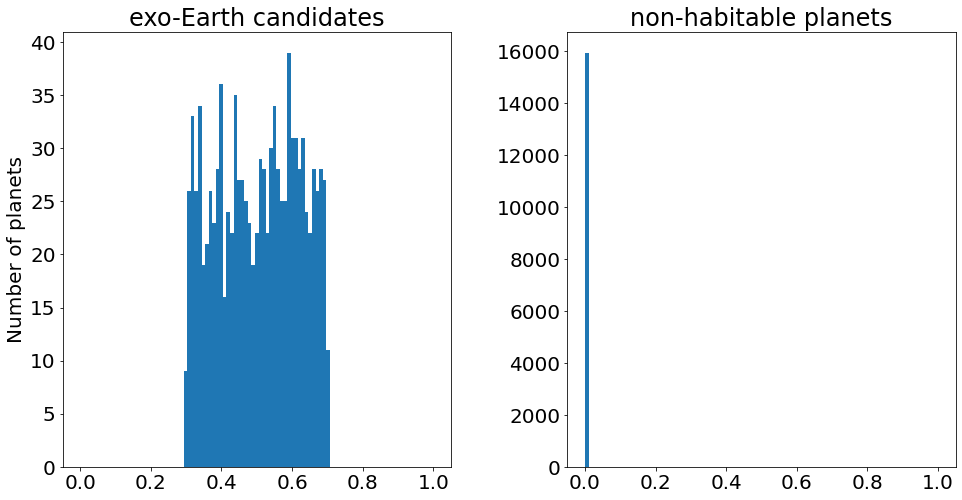

In [9]:
fig, ax = plt.subplots(ncols=2, figsize=(16,8))

f_ocean = sample['f_ocean']
EEC = sample['EEC']

# EECs
bins = np.linspace(0., 1, 100)
ax[0].hist(f_ocean[EEC], bins=bins)
ax[0].set_title('exo-Earth candidates')
ax[0].set_ylabel('Number of planets')

# Non-EECs
ax[1].hist(f_ocean[~EEC], bins=bins)
ax[1].set_title('non-habitable planets')

plt.subplots_adjust(wspace=0.3)

Of course, you may wish to change the `oceans` function later, and it would be tiring to add it to the Generator again each time. Instead, we can point the Generator to a Python file containing your function, which must be saved under ``bioverse/functions/``.

In [10]:
# Reload the generator to erase the previously-added step
generator = Generator('transit')

# Write the function definition as a string
func = """
# Define a function that accepts and returns a Table object
def oceans(d, f_ocean_min=0, f_ocean_max=1):
    # First, assign zero for all planets
    d['f_ocean'] = np.zeros(len(d))

    # Next, assign a random non-zero value for exo-Earth candidates
    EEC = d['EEC']
    d['f_ocean'][EEC] = np.random.uniform(f_ocean_min, f_ocean_max, size=EEC.sum())

    # Finally, return the Table with its new column
    return d
"""

# Save the function to a .py file
with open(ROOT_DIR+'/example_oceans.py', 'w') as f:
    f.write(func)

# Insert this function into the Generator and specify the filename
generator.insert_step('oceans', filename='example_oceans.py')

# Verify that the new step has been added
generator

Generator with 13 steps:
 0: Function 'create_stars_Gaia' with 6 keyword arguments.
 1: Function 'create_planets_SAG13' with 9 keyword arguments.
 2: Function 'assign_orbital_elements' with 1 keyword arguments.
 3: Function 'geometric_albedo' with 2 keyword arguments.
 4: Function 'impact_parameter' with 1 keyword arguments.
 5: Function 'assign_mass' with no keyword arguments.
 6: Function 'compute_habitable_zone_boundaries' with no keyword arguments.
 7: Function 'compute_transit_params' with no keyword arguments.
 8: Function 'classify_planets' with no keyword arguments.
 9: Function 'scale_height' with no keyword arguments.
10: Function 'Example1_water' with 3 keyword arguments.
11: Function 'Example2_oxygen' with 2 keyword arguments.
12: Function 'oceans' with 2 keyword arguments.

Now, any changes you make to the `oceans` function under `example_oceans.py` will automatically be applied. Finally, you will want to save this Generator under a new name, so that you don't have to re-add the new step every time you load Bioverse:

In [11]:
# Save the new Generator
generator.save('transit_oceans')

# Reload it
generator = Generator('transit_oceans')

The following lines of code will clean up the files created during this exercise:

In [12]:
trash = [ROOT_DIR+'/Objects/Generators/transit_oceans.pkl', ROOT_DIR+'/example_oceans.py']
for filename in trash:
    if os.path.exists(filename):
        os.remove(filename)

The next example will translate this simulated sample of planetary systems into a dataset from a transit spectroscopy survey.